Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. 
Эксперимент проходил с 2022-10-03 по 2022-10-09 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

    Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
    Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
    Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
    Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

Ваше решение — это ссылка на merge request с проведенным анализом.

In [1]:
import pandas as pd
import pandahouse
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from scipy import stats
%matplotlib inline

In [30]:
import pandahouse

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20221020'
}

q = '''SELECT exp_group,
              user_id,
              sum(action = 'like') likes,
              sum(action = 'view') views,
              likes / views ctr
        FROM {db}.feed_actions 
        where toDate(time) between '2022-10-03' and '2022-10-09'
            and exp_group in (1,2)
        group by exp_group, user_id
     '''

In [31]:
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [32]:
df.groupby('exp_group')['user_id'].count()

exp_group
1    10079
2     9952
Name: user_id, dtype: int64

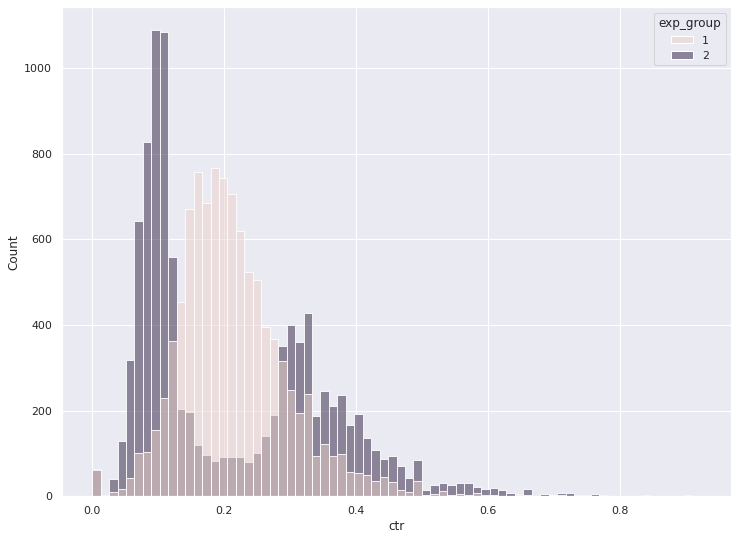

In [33]:
sns.set(rc={'figure.figsize': (12,9)})
sns.histplot(data=df, x='ctr', hue='exp_group');

In [9]:
df.groupby('exp_group')['ctr'].agg(['mean','median'])

,mean,median
exp_group,,
1,0.215605,0.203125
2,0.214419,0.142857


Гипотезы:

H0: CTR контрольной группы и CTR эспериментальной группы не различаются 

H1: CTR контрольной группы и CTR эспериментальной группы различаются 

alpha = 5%

In [34]:
# T-test
stats.ttest_ind(df[df['exp_group'] == 1]['ctr'],
               df[df['exp_group'] == 2]['ctr'],
               equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

Не можем отклонить нулевую гипотезу, p-value выше установленного alpha. Не можем приниять альтернативную гипотезу. Разница CTR статистически не значима

In [35]:
# U-test
stats.mannwhitneyu(df[df['exp_group'] == 1]['ctr'],
                   df[df['exp_group'] == 2]['ctr'])

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Отклоняем нулевую гипотезу, p-value ниже установленного alpha. Принимаем альтернативную гипотезу. Разница CTR статистически значима

Попробуем сгладить CTR

In [16]:
def smothed_ctr(user_likes, user_views, global_ctr, alpha):
    ctr_ = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return ctr_

In [36]:
global_ctr_1 = df[df['exp_group'] == 1]['likes'].sum() / df[df['exp_group'] == 1]['views'].sum()
global_ctr_2 = df[df['exp_group'] == 2]['likes'].sum() / df[df['exp_group'] == 2]['views'].sum()

In [38]:
df['smothed_ctr_1'] = df.apply(lambda x: smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
df['smothed_ctr_2'] = df.apply(lambda x: smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [39]:
df.head()

,exp_group,user_id,likes,views,ctr,smothed_ctr_1,smothed_ctr_2
0,1,109963,3,15,0.200000,0.202007,0.199515
1,1,26117,32,141,0.226950,0.226302,0.225961
2,1,138232,18,73,0.246575,0.244104,0.243465
3,1,26295,33,122,0.270492,0.268033,0.267640
4,1,18392,7,32,0.218750,0.217301,0.215954


In [42]:
# T-test
stats.ttest_ind(df[df['exp_group'] == 1]['smothed_ctr_1'],
               df[df['exp_group'] == 2]['smothed_ctr_2'],
               equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

In [43]:
# U-test
stats.mannwhitneyu(df[df['exp_group'] == 1]['smothed_ctr_1'],
                   df[df['exp_group'] == 2]['smothed_ctr_2'])

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

Отклоняем нулевую гипотезу, p-value ниже установленного alpha. 

Принимаем альтернативную гипотезу. 

Разница CTR статистически значима в обоих тестах

In [45]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstrap1 = stats.poisson(1).rvs(
        (2000, len(likes1))).astype(np.int64)
    
    poisson_bootstrap2 = stats.poisson(1).rvs(
        (2000, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstrap1 * likes1).sum(axis=1) / (poisson_bootstrap1 * views1).sum(axis=1)
    globalCTR2 = (poisson_bootstrap2 * likes2).sum(axis=1) / (poisson_bootstrap2 * views2).sum(axis=1)
    
    return globalCTR1, globalCTR2

In [50]:
likes1 = df[df['exp_group'] == 1].likes.to_numpy()
likes2 = df[df['exp_group'] == 2].likes.to_numpy()
views1 = df[df['exp_group'] == 1].views.to_numpy()
views2 = df[df['exp_group'] == 2].views.to_numpy()

<AxesSubplot:ylabel='Count'>

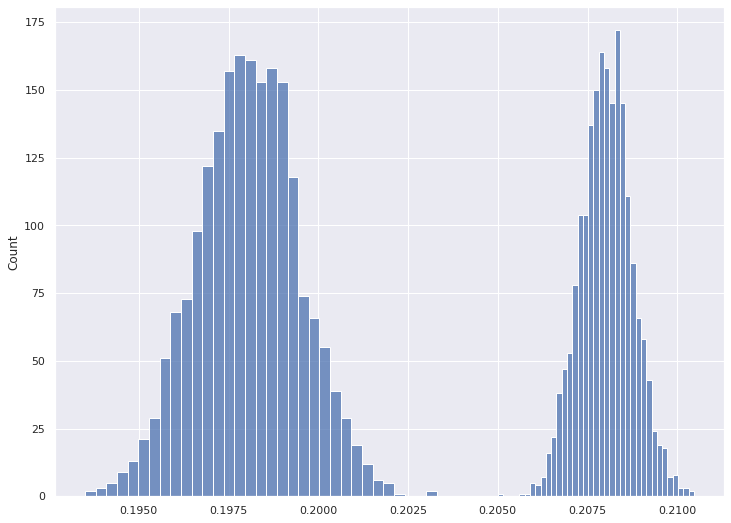

In [51]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

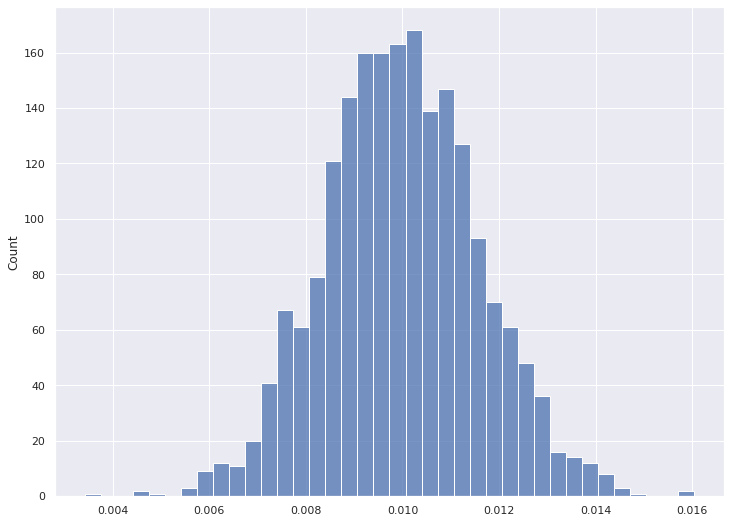

In [53]:
sns.histplot(ctr1 - ctr2)

In [55]:
ctr2

array([0.19957455, 0.19871301, 0.19921672, ..., 0.19652692, 0.1974348 ,
       0.20023986])

In [57]:
stats.t.interval(alpha=0.99, df=len(ctr1)-1, loc=np.mean(ctr1), scale=stats.sem(ctr1)) 

(0.20797685812851124, 0.2080614052996766)

In [58]:
stats.t.interval(alpha=0.99, df=len(ctr2)-1, loc=np.mean(ctr2), scale=stats.sem(ctr2)) 

(0.1979564441796522, 0.19812105612308845)

Видим, что при даже при уровне достоверности в 99% интервалы не пересекаются, соотвественно мы отклоняем Н0, разница статистически значима.

Рекомендации

Гипотеза, что новый алгоритм во 2-й группе приведет к увеличению CTR, подтвердилась

Рекомендация: не раскатывать новый алгоритм на всех новых пользователей.